In [1]:
# Cell 1: 环境与导入
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt


# 路径设置
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

# 字体设置 (参考之前的代码，确保显示中文)
import platform
font_name = 'SimHei' if platform.system() == "Windows" else 'Arial Unicode MS'
sns.set_theme(style="whitegrid", font=font_name)

from src.analyzer.semantic_feature_analysis import SemanticFeatureAnalyzer

In [3]:
# 指定数据文件路径
data_file = '../data/output/2_semantic_annotation.jsonl'

# 加载数据
# limit 用于限定数据数量
# 如 limit=10 只加载 10 条数据
# 处理所有数据可设置 limit=None 
analyzer = SemanticFeatureAnalyzer(data_file)
analyzer.load_and_count()

正在统计语义主类分布: ../data/output/2_semantic_annotation.jsonl ...


Scanning Semantics: 305it [00:00, 9014.80it/s]

统计完成！版本: ['source', 'deepseek-v3.2', 'human', 'qwen3-max']


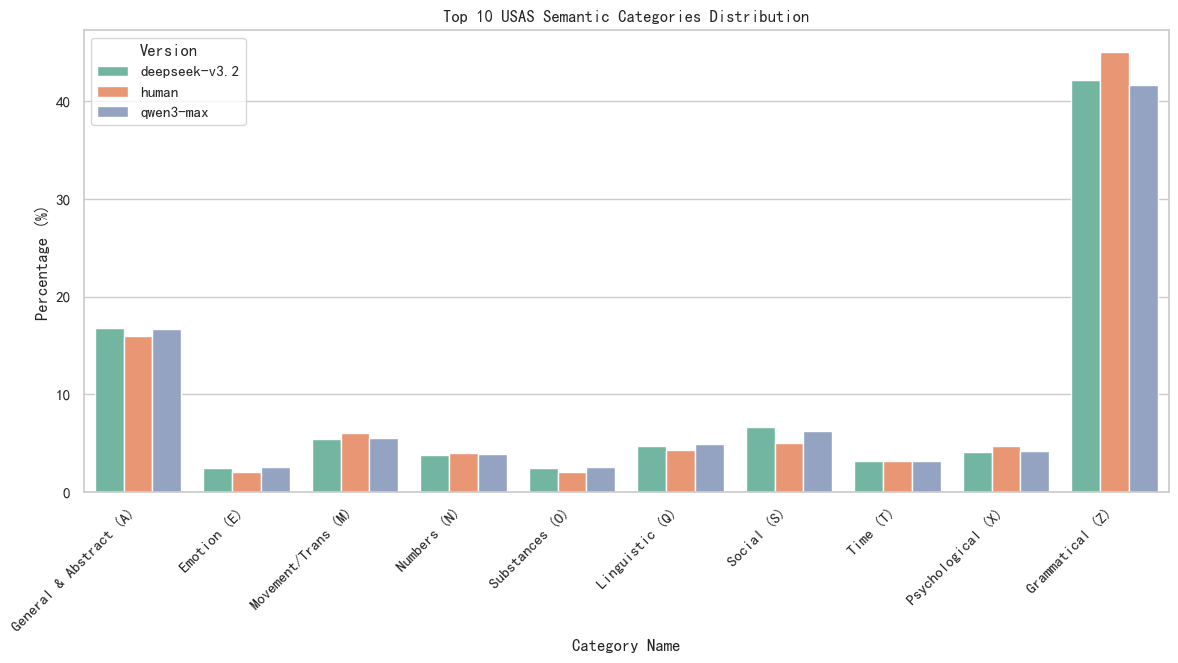

In [4]:
# Cell 2: 全景概览 (Overview)
# 看看哪些语义类别在文本中占比最高（通常是 Z-语法词 和 A-通用动作）

# 获取所有类别的统计
df_all = analyzer.get_distribution_df(versions=['human', 'deepseek-v3.2', 'qwen3-max'])

# 为了图表清晰，我们只展示占比最高的 Top 10 类别
# 计算所有版本的平均占比来排序
top_cats = df_all.groupby('Category Code')['Percentage'].mean().sort_values(ascending=False).head(10).index.tolist()
df_top = df_all[df_all['Category Code'].isin(top_cats)]

plt.figure(figsize=(14, 6))
sns.barplot(x="Category Name", y="Percentage", hue="Version", data=df_top, palette="Set2")
plt.title("Top 10 USAS Semantic Categories Distribution")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage (%)")
plt.show()

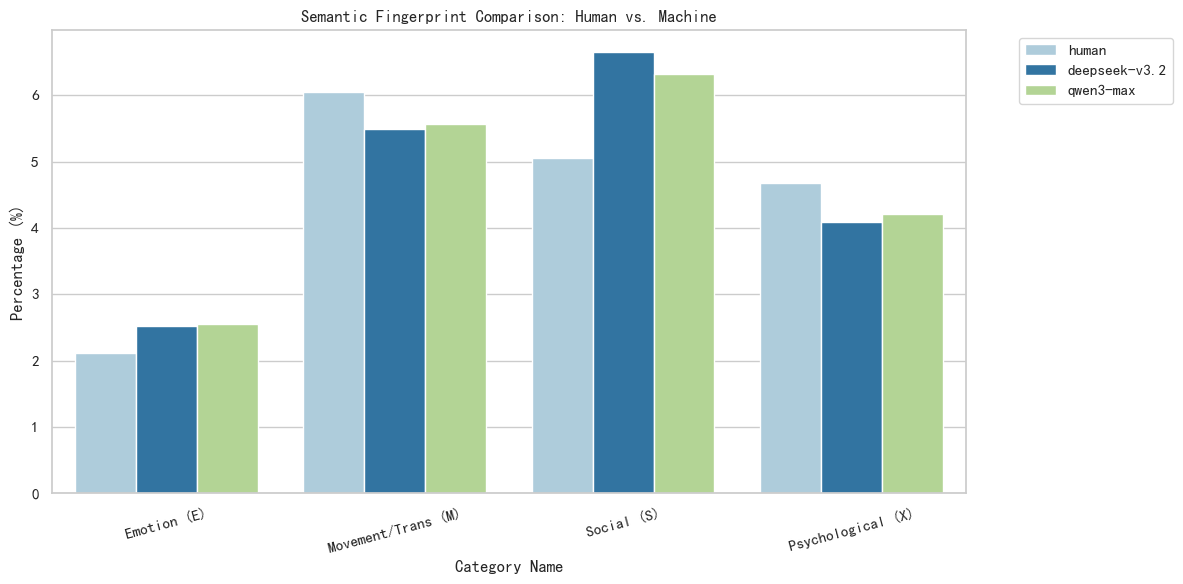

Version,deepseek-v3.2,human,qwen3-max
Category Name,,,
Emotion (E),2.52,2.12,2.55
Movement/Trans (M),5.50,6.05,5.57
Psychological (X),4.08,4.68,4.22
Social (S),6.65,5.06,6.32


In [8]:
# Cell 3: 用户自定义深度分析 (Deep Dive)
# 这是本案例的核心：用户指定想看的类别

# === 用户配置区 ===
# 假设我们想研究：
# 1. E (Emotion): 情感是否丢失？
# 2. X (Psychological): 心理描写是否到位？
# 3. A (General): 动作/通用词的使用频率
# 4. Z (Grammatical): 功能词（虚词）的使用频率 -> 侧面反映显化/隐化
target_cats = ['E', 'X', 'M', 'S'] 
# =================

df_focus = analyzer.get_distribution_df(
    target_categories=target_cats,
    versions=['human', 'deepseek-v3.2', 'qwen3-max']
)

plt.figure(figsize=(12, 6))
# 使用 'dodge=True' 让柱子并排显示
sns.barplot(x="Category Name", y="Percentage", hue="Version", data=df_focus, palette="Paired")

plt.title("Semantic Fingerprint Comparison: Human vs. Machine")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # 图例放外边
plt.tight_layout()
plt.show()

# 打印详细数据表
pivot_df = df_focus.pivot(index="Category Name", columns="Version", values="Percentage")
display(pivot_df.round(2))

In [17]:
import json
import os

def find_semantic_divergence(jsonl_path, target_cat='S', machine_ver='deepseek-v3.2'):
    """
    寻找语义分歧：查找机器使用了特定类别，但人类没用(或用得少)的例子
    """
    print(f"正在检索差异案例... (目标类别: {target_cat}, 对比: Human vs {machine_ver})")
    
    divergent_examples = []
    
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line_no, line in enumerate(f):
            try:
                rec = json.loads(line)
                
                # 1. 获取 Human 和 Machine 的标注数据
                # 增加 .get() 的防空保护
                targets = rec.get('annotations', {}).get('targets_en', {})
                if not targets: continue

                human_data = targets.get('human')
                machine_data = targets.get(machine_ver)
                
                # 确保数据非空
                if not human_data or not machine_data:
                    continue
                    
                # === 内部辅助函数 (修复版) ===
                def get_cat_words(tags_list):
                    # 【修复 1】: 核心防崩逻辑
                    # 如果 tags_list 是 None (JSON null)，直接返回空列表
                    if not tags_list:
                        return []
                    
                    result = []
                    for t in tags_list:
                        # 【修复 2】: 确保 t 是字典且包含 'tag' 键
                        if not isinstance(t, dict): continue
                        
                        tag_code = t.get('tag', '')
                        # 确保 tag_code 是字符串
                        if tag_code and str(tag_code).startswith(target_cat):
                            text = t.get('text', 'unknown')
                            result.append(f"{text} ({tag_code})")
                    return result

                # 2. 提取词汇
                # 即使 JSON 里是 null，函数内部也会处理
                human_s_words = get_cat_words(human_data.get('usas_tags'))
                machine_s_words = get_cat_words(machine_data.get('usas_tags'))
                
                # 3. 判定逻辑
                if len(machine_s_words) > len(human_s_words) and len(machine_s_words) > 0:
                    divergent_examples.append({
                        "id": rec['id'],
                        "source": rec['annotations']['source_zh'].get('raw_text', ''),
                        "human_text": human_data.get('raw_text', ''),
                        "human_s_tags": human_s_words,
                        "machine_text": machine_data.get('raw_text', ''),
                        "machine_s_tags": machine_s_words,
                        "diff_count": len(machine_s_words) - len(human_s_words)
                    })
            except Exception as e:
                # 打印错误但不中断，方便调试
                print(f"Skipping line {line_no} due to error: {e}")
                continue
    
    # 按差异大小排序
    divergent_examples.sort(key=lambda x: x['diff_count'], reverse=True)
    return divergent_examples

# === 再次运行检索 ===
# 确保变量 data_file 指向正确的文件路径
# data_file = '../data/2_semantic_output/mac_multiver_semantic.jsonl' 

# 运行
examples = find_semantic_divergence(data_file, target_cat='S', machine_ver='deepseek-v3.2')

print(f"共找到 {len(examples)} 个差异句。展示 Top 5 典型案例：")

for i, ex in enumerate(examples[:20]):
    print(f"\n[{i+1}] ID: {ex['id']}")
    print(f"原文: {ex['source']}")
    print("-" * 60)
    print(f"Human   (S类: {len(ex['human_s_tags'])}): {ex['human_text']}")
    print(f"        >> {ex['human_s_tags']}") 
    print("-" * 60)
    print(f"Machine (S类: {len(ex['machine_s_tags'])}): {ex['machine_text']}")
    print(f"        >> {ex['machine_s_tags']}")
    print("=" * 60)

正在检索差异案例... (目标类别: S, 对比: Human vs deepseek-v3.2)
共找到 111 个差异句。展示 Top 5 典型案例：

[1] ID: 000068
原文: 吕留良心怀故国，不肯在清朝做官。 当地大吏仰慕他声名，保荐他为“山林隐逸”，应征赴朝为官，吕留良誓死相拒，大吏不敢再逼。
------------------------------------------------------------
Human   (S类: 4): In spite of Lü Liuliang's patriotic unwillingness to serve, a local official, impressed by what he had heard of Lü's reputation, had once sought to recommend him as a 'hidden talent' meriting a summons to the Manchu Court for suitable employment; but Lü had made it clear that he would die rather than accept such a tones, recited summons, and the matter had been dropped.
        >> ['serve (S8)', 'official (S2)', 'reputation (S1.2.5)', 'meriting (S1.1.4)']
------------------------------------------------------------
Machine (S类: 11): Lü Liuliang, who remained loyal to the fallen Ming dynasty, refused to serve as an official under the Qing regime. The local high-ranking officials, admiring his reputation, recommended him as a "recluse of the mountains and